In [1]:
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2, calendar, time, pickle, PIL
from sklearn.decomposition import PCA
%matplotlib inline

def L2(x, y): # Euclidean Distance
    sum = 0.0
    for i in range(len(x)):
        sum = sum + (x[i] - y[i]) * (x[i] - y[i])
    return np.math.sqrt(sum)

def DisplayTree(root): # Preorder Display
    print(root.point)
    if root.left:
        DisplayTree(root.left)
    if root.right:
        DisplayTree(root.right)

def NNS(dist_array=None, tmp_dist=0.0, point=None, k=1, NN=None,):
    """Nearest Neighbor Search Algorithm"""
    if tmp_dist <= np.min(dist_array) : 
            for i in range(k-1,0,-1) :
                dist_array[i] = dist_array[i-1]
                NN[i] = NN[i-1]    
            dist_array[0] = tmp_dist
            NN[0] = point                
            return NN, dist_array
    for i in range(k): # Find more nn point in the other hyperplanes
        if (dist_array[i] <= tmp_dist) and (dist_array[i+1] >= tmp_dist):
            for j in range(k-1,i,-1) : 
                dist_array[j] = dist_array[j-1]
                NN[j] = NN[j-1]
            dist_array[i+1] = tmp_dist
            NN[i+1] = point
            break
    return NN, dist_array

class Node(object):
    """Construct Node"""
    def __init__(self, point=None, plane=None, left=None, right=None):
        self.point = point
        self.plane = plane
        self.left = left
        self.right = right

class KDTree(object):
    """Construct the Tree structure"""
    def __init__(self, data=None):
        def createNode(plane=None, dataset=None): # Create nodes
            if  len(dataset) == 0:
                return None
            dataset = list(dataset)
            data_set = dataset.sort(key=lambda x: x[plane])
            dataset = np.array(dataset)
            # Find the median
            pivot = len(dataset) // 2
            return Node(dataset[pivot], plane,
                          createNode(_max(dataset[:pivot]),dataset[:pivot]), 
                          createNode(_max(dataset[pivot+1:]),dataset[pivot+1:]))
        
        # Find the root of the tree
        def _max(dataset=None):
            l = len(dataset)
            if  l == 0: 
                return 0
            m = np.mean(dataset,axis=0)
            diff = dataset - m
            var = np.sum(diff ** 2,axis=0)/l
            res = np.where(var == np.max(var))
            return res[0][0]
        
        self.root = createNode(_max(data), data)


In [2]:
def searchKDTree(KDTree=None, query=None, k=1):  
    """Search KD Tree for NNS"""
    if k == 0: 
        return None
    tempN = KDTree.root
    NN = [tempN.point] * k
    dist_array = [float("inf")] * k
    nodes = []
    
    def Path(query=None, tempN=None, nodes=None, dist_array=None, NN=None):
        """Path of the Search in KD Tree"""
        while tempN:
            nodes.append(tempN)
            plane = tempN.plane
            point = tempN.point
            tmp_dist = L2(point, query)
            if tmp_dist < np.max(dist_array) :
                NN, dist_array = NNS(dist_array, tmp_dist, point, k, NN)
            if  query[plane] <= point[plane] : 
                tempN = tempN.left
            else : 
                tempN = tempN.right
        return NN, dist_array
    NN, dist_array = Path( query, tempN, nodes, dist_array, NN)
    
    while nodes:
        last_node = nodes.pop()
        plane = last_node.plane
        point = last_node.point
        if not abs(query[plane] - point[plane]) >= np.max(dist_array) :
            if (query[plane] <= point[plane]):
                tempN = last_node.right
            else:
                tempN = last_node.left
            if tempN:
                NN, dist_array = Path( query, tempN, nodes, dist_array, NN)
    return NN, dist_array 


In [3]:
data = [[4,1,3,5],[3,6,5,7],[5,2,6.5,5],[4.8,4.2,5,8],[1,1,8,6],[1,6,5,3],[4.1,3.7,2,5],[4.7,4.1,5,9],[2,4,6,8.7]]  # samples
data = np.asarray(data)
kd = KDTree(data)

In [4]:
DisplayTree(kd.root)

[1. 1. 8. 6.]
[4.1 3.7 2.  5. ]
[5.  2.  6.5 5. ]
[4. 1. 3. 5.]
[1. 6. 5. 3.]
[4.7 4.1 5.  9. ]
[3. 6. 5. 7.]
[2.  4.  6.  8.7]
[4.8 4.2 5.  8. ]


In [5]:
ktest = 9
res, vecdisctances = searchKDTree(kd, [0,3,2,0], ktest)

In [6]:
print (res)
print()
print(vecdisctances)

[array([1., 6., 5., 3.]), array([4.1, 3.7, 2. , 5. ]), array([4., 1., 3., 5.]), array([5. , 2. , 6.5, 5. ]), array([3., 6., 5., 7.]), array([1., 1., 8., 6.]), array([2. , 4. , 6. , 8.7]), array([4.8, 4.2, 5. , 8. ]), array([4.7, 4.1, 5. , 9. ])]

[5.291502622129181, 6.5038450166036395, 6.782329983125268, 8.440971508067067, 8.717797887081348, 8.774964387392123, 9.833107342035882, 9.873196037757987, 10.644247272588137]


#### The following loads in the cifar-10-dataset training and testing files. There are 50000 training images and 10000 test images. (32x32 colour images in 10 classes). They are subset of the 80 million tiny images dataset.
#### Build the 50000 color images in KD-Tree and use one of the test images to search the k-nearest similar image.
#### Download Link: https://www.cs.toronto.edu/~kriz/cifar.html

In [7]:
trainigDataFiles = ('./cifar-10-batches-py/data_batch_1', './cifar-10-batches-py/data_batch_2', './cifar-10-batches-py/data_batch_3', './cifar-10-batches-py/data_batch_4','./cifar-10-batches-py/data_batch_5') #An array of filenames containing the training data set
testDataFile = './cifar-10-batches-py/test_batch'
pcaDim = 10

In [8]:
# HOG Parameters:
winSize = 32
blockSize = 12
blockStride = 4
cellSize = 4
nbins = 18
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = True
hog = cv2.HOGDescriptor((winSize,winSize),(blockSize, blockSize),(blockStride,blockStride),(cellSize,cellSize),nbins,derivAperture, winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels,signedGradient)

In [9]:
def loadData(filename):
    '''
    Load the data from the given filename
    '''
    f = open(filename, 'rb')
    theSet = pickle.load(f,encoding='latin1')
    f.close()

    return theSet['data'], theSet['labels']

In [10]:
def convertImages(origImages):
    '''
    Convert the images from CIFAR-10 format, to an array of 10000 images each is 32 X 32 X 3 size
    images: array of images each in 32 X 32 X 3 size
    '''
    images = np.reshape(origImages,(-1, channels, imageSize, imageSize))
    images = np.transpose(images, (0,2,3,1))

    return images

In [11]:
imageSize = 32  #The size of the original image - in pixels - assuming this is a square image
channels = 3    #The number of channels of the image. A RBG color image, has 3 channels
classes = 10    #The number of classes available for this dataset
trainingDataSize = 50000    #The number of images in the training set
testDataSize = 10000        #The number of images in the test set

In [12]:
def loadTestData(filename):
    '''
    Load the test data
    '''
    origTestImages, testLabels = loadData(filename)
    testImages = convertImages(origTestImages)

    return testImages, testLabels

In [13]:
def loadTrainingData(filenames):
    '''
    Load all the training data from all files
    '''
    trainingImages = np.zeros(shape=[trainingDataSize, imageSize, imageSize, channels], dtype=np.uint8)
    trainingLabels = np.zeros(shape=[trainingDataSize], dtype=int)

    start=0
    for fileName in filenames:
        origImages, labels = loadData(fileName)
        images = convertImages(origImages)

        numOfImages = len(images);
        end = start + numOfImages;
        trainingImages[start:end, :] = images
        trainingLabels[start:end] = labels
        start = end

    return trainingImages, trainingLabels

In [14]:
def currentTime():
    '''
    Returns the current time in seconds since EPOC
    '''
    return calendar.timegm(time.gmtime())

In [15]:
def grid_display(list_of_images, no_of_columns=2, figsize=(10,10)):
    """Display images in grid"""
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        if column == no_of_columns+1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis('off')

In [16]:
def calcHOG(images):
    '''
    Calculate the HOG (Histogram of Oriented Gradients) feature descriptors of the given images
    Returns:
    --------
    hogDescriptors: an array of HOG vectors, 5832 components each
    '''
    hogDescriptors = []
    for image in images:
        hogDescriptors.append(hog.compute(image))
    hogDescriptors = np.squeeze(hogDescriptors)
    return hogDescriptors

In [17]:
print("Loading the training set..."),
tik = currentTime()
trainingImages, trainingLabels = loadTrainingData(trainigDataFiles)
print("Took: " + str(currentTime()-tik) + " sec" )

Loading the training set...
Took: 0 sec


In [33]:
print(trainingImages.shape)

(50000, 32, 32, 3)


In [18]:
print("Creating HOG descriptors from the training set..."),
tik = currentTime()
trainHogDescriptors = calcHOG(trainingImages)
print("Took: " + str(currentTime() - tik) + " sec")

Creating HOG descriptors from the training set...
Took: 8 sec


In [31]:
print(trainHogDescriptors.shape)

(50000, 5832)


In [19]:
print("Reducing the dimension of the HOG descriptors to " + str(pcaDim) + "..."),
tik = currentTime()
pca = PCA(pcaDim)
trainHogProjected = pca.fit_transform(trainHogDescriptors)
print("Took: " + str(currentTime() - tik) + " sec")

Reducing the dimension of the HOG descriptors to 10...
Took: 9 sec


In [32]:
print(trainHogProjected.shape)

(50000, 10)


In [20]:
pcaFileName = 'pca'
print("Save it as a PCA file..."), 
tik = currentTime() 
pcaFile = open(pcaFileName, 'wb')
pickle.dump(pca, pcaFile)
pcaFile.close()
print("Took: " + str(currentTime() - tik) + " sec")

Save it as a PCA file...
Took: 0 sec


In [21]:
print("Build Image KD-tree...")
kdnew = KDTree(np.asarray(trainHogProjected))
print("Took: " + str(currentTime() - tik) + " sec")

Build Image KD-tree...
Took: 3 sec


In [22]:
print("Loading the test set..."),
tik = currentTime()
testImages, testLabels = loadTestData(testDataFile)
print("Took: " + str(currentTime() - tik) + " sec")

Loading the test set...
Took: 0 sec


In [23]:
print("Creating HOG descriptors from the test set..."),
tik = currentTime()
testHogDescriptors = calcHOG(testImages);
print("Took: " + str(currentTime() - tik) + " sec")

Creating HOG descriptors from the test set...
Took: 2 sec


In [24]:
print("Reducing the dimension of the HOG descriptors to " + str(pcaDim) + "..."),
tik = currentTime()
testHogProjected = pca.transform(testHogDescriptors)
print("Took: " + str(currentTime() - tik) + " sec")

Reducing the dimension of the HOG descriptors to 10...
Took: 0 sec


In [25]:
k = 8 # Number of Search
t_img = testHogProjected[1] # Test image to Search in the Tree

print("KNN Search in KD-tree...")
result, distMat = searchKDTree(kdnew, np.asarray(t_img), k)
print("Took: " + str(currentTime() - tik) + " sec")

KNN Search in KD-tree...
Took: 0 sec



Test Image...


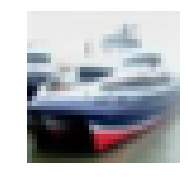

In [26]:
testx = np.where(np.prod(testHogProjected == t_img, axis = -1))
testy = testx[0][0]
testimg = testImages[testy]
img = PIL.Image.fromarray(testimg)
plt.subplot(1, 2, 1)
plt.imshow(img, interpolation='none')
plt.axis('off')
print()
print("Test Image...")


8  Nearest Images...


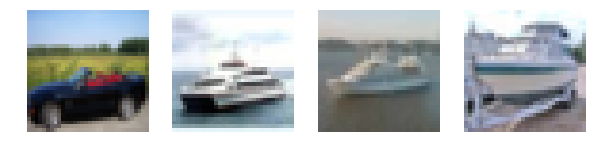

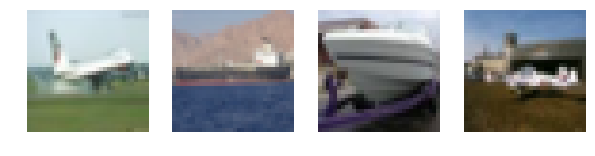

In [27]:
print()
# print("PCA's n_components: ", pcaDim,"\n")
print(k, " Nearest Images...")
Imagess = []
for i in range(k):
    indx = np.where(np.prod(trainHogProjected == result[i], axis = -1))
    indy = indx[0][0]
    res_img = trainingImages[indy]
    img_tr = PIL.Image.fromarray(res_img)
    Imagess.append(img_tr)

grid_display(Imagess, 4, (10,10))

In [28]:
# im = PIL.Image.open("airplane.jpg")
# im = im.resize((32, 32), Image.ANTIALIAS)
# im = np.asarray(im)
# # img = im
# # print(im)
# img = convertImages(im)
# # print(img)
# testimg2 = calcHOG(img);
# testimg2 = testimg2.reshape(1,-1)
# testproj = pca.transform(testimg2)

# res, distM = searchKDTree(kdnew,testproj[0], k)

# imgg = PIL.Image.fromarray(im)
# plt.subplot(1, 2, 1)
# plt.imshow(imgg, interpolation='none')
# plt.axis('off')
# print()
# print("Test Image...")

In [29]:
# Imagess2 = []
# for i in range(k):
#     indx = np.where(np.prod(trainHogProjected == res[i], axis = -1))
#     indy = indx[0][0]
#     res_img = trainingImages[indy]
#     img_tr = PIL.Image.fromarray(res_img)
#     Imagess2.append(img_tr)
# grid_display(Imagess2, 4, (10,10))